Regression model to predict House price
 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


import data 

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('/content/data.csv')
data.sample(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1420,2014-05-27 00:00:00,495000.0,3.0,2.50,1750,1548,3.0,0,0,3,1750,0,2013,1923,3933 S Brandon St,Seattle,WA 98118,USA
28,2014-05-02 00:00:00,675000.0,5.0,2.50,2820,67518,2.0,0,0,3,2820,0,1979,2014,23525 SE 32nd Way,Issaquah,WA 98029,USA
1891,2014-06-04 00:00:00,499950.0,3.0,2.50,1520,2208,2.0,0,0,3,1040,480,2007,0,2537 13th Ave W,Seattle,WA 98119,USA
4075,2014-07-08 00:00:00,362000.0,5.0,3.00,1810,3000,2.0,0,0,3,1810,0,1998,2006,4519 33rd Ave S,Seattle,WA 98118,USA
2666,2014-06-17 00:00:00,605000.0,3.0,2.25,2010,10760,2.0,0,0,3,2010,0,1985,0,14150 176th Ave NE,Redmond,WA 98052,USA


deleting columns 


In [ ]:
#categorical column not useful in prediction
del data['date']
del data['street']
del data['statezip']
del data['country']

In [ ]:
# How old is the house?
data['house_age'] = [2021 - yr_built for yr_built in data['yr_built']]

# Was the house renovated and was the renovation recent?
data['was_renovated'] = [1 if yr_renovated != 0 else 0 
    for yr_renovated in data['yr_renovated']]
data['was_renovated_10_yrs'] = [1 if (2021 - yr_renovated) <= 10 
    else 0 for yr_renovated in data['yr_renovated']]
data['was_renovated_30_yrs'] = [1 if 10 < (2021 - yr_renovated) <= 30
    else 0 for yr_renovated in data['yr_renovated']]

# Drop original columns
data = data.drop(['yr_built', 'yr_renovated'], axis=1)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,city,house_age,was_renovated,was_renovated_10_yrs,was_renovated_30_yrs
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,Shoreline,66,1,0,1
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,Seattle,100,0,0,0
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,Kent,55,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,Bellevue,58,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,Redmond,45,1,0,1


data preprocessing 

In [ ]:
def remap_location(data: pd.DataFrame, 
                   location: str, 
                   threshold: int = 50) -> str:
    if len(data[data['city'] == location]) < threshold:
        return 'Rare'
    return location

In [ ]:
data['city'] = data['city'].apply(
    lambda x: remap_location(data=data, location=x)
)
data.sample(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,city,house_age,was_renovated,was_renovated_10_yrs,was_renovated_30_yrs
3910,1.195000e+06,5.0,3.00,3420,18129,2.0,0,0,3,2540,880,Mercer Island,69,1,0,1
3337,1.355000e+06,3.0,1.50,2680,4775,2.0,0,2,5,1880,800,Seattle,108,0,0,0
4561,4.331111e+05,3.0,2.25,1370,1524,3.0,0,0,3,1370,0,Seattle,16,0,0,0
3404,3.500000e+05,3.0,2.25,1780,16290,2.0,0,0,4,1780,0,Renton,34,0,0,0
411,2.700000e+05,3.0,1.50,1500,6337,1.0,0,0,5,1500,0,Seattle,68,0,0,0
2159,9.650000e+05,4.0,2.25,3160,34560,1.0,0,0,4,3160,0,Woodinville,40,0,0,0
2480,8.499000e+05,2.0,2.00,2280,641203,2.0,0,0,3,2280,0,Rare,31,1,0,1
3936,4.055000e+05,2.0,2.75,1350,1252,2.0,0,0,3,1120,230,Seattle,15,0,0,0
1298,3.750000e+05,2.0,2.50,750,1430,2.0,0,0,3,750,0,Seattle,15,0,0,0
461,8.000000e+05,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,Rare,14,0,0,0


EDA

Data distribution on price

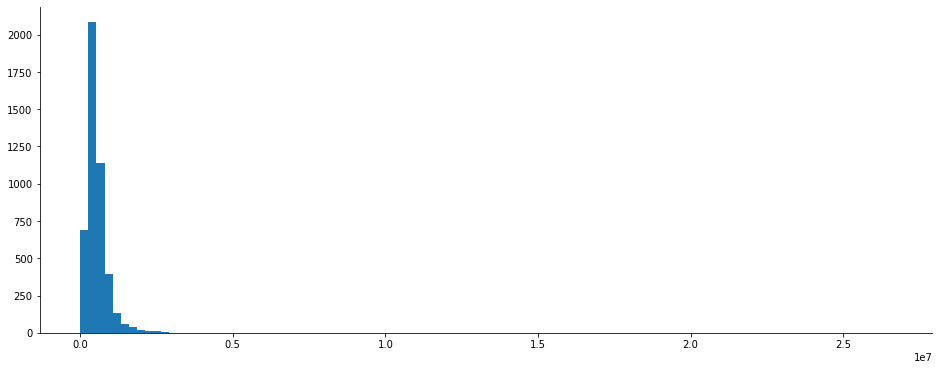

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

plt.hist(data['price'], bins=100);

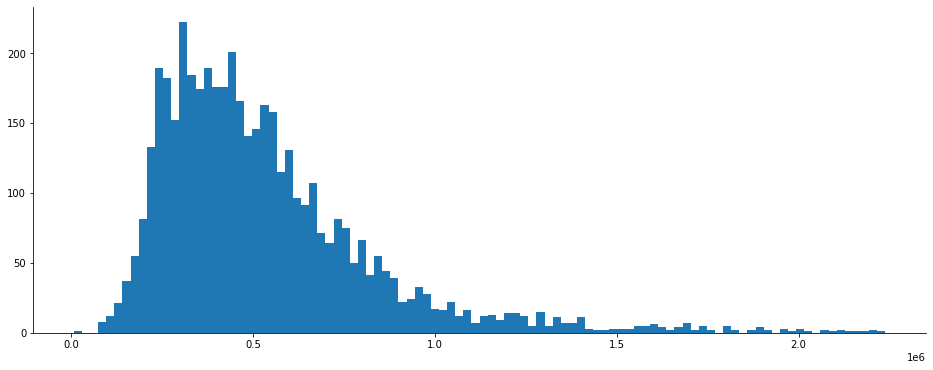

In [ ]:
from scipy import stats

# Calculate Z-values
data['price_z'] = np.abs(stats.zscore(data['price']))

# Filter out outliers
data = data[data['price_z'] <= 3]

# Remove houses listed for $0
data = data[data['price'] != 0]

# Drop the column
data = data.drop('price_z', axis=1)

# Draw a histogram
plt.hist(data['price'], bins=100);

One hot encoding 

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

transformer = make_column_transformer(
    (MinMaxScaler(), 
        ['sqft_living', 'sqft_lot','sqft_above', 
         'sqft_basement', 'house_age']),
    (OneHotEncoder(handle_unknown='ignore'), 
        ['bedrooms', 'bathrooms', 'floors', 
         'view', 'condition'])
)

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

split dataset

In [ ]:
# Fit
transformer.fit(X_train)

# Apply the transformation
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


Model

In [ ]:
tf.random.set_seed(42)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(
    loss=rmse,
    optimizer=Adam(),
    metrics=[rmse]
)

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
113/113 [==============================] - 2s 3ms/step - loss: 607305.5000 - rmse: 607324.4375
Epoch 2/100
113/113 [==============================] - 0s 4ms/step - loss: 428813.9375 - rmse: 428630.6562
Epoch 3/100
113/113 [==============================] - 0s 4ms/step - loss: 268001.8750 - rmse: 267976.8438
Epoch 4/100
113/113 [==============================] - 0s 4ms/step - loss: 248637.9062 - rmse: 248579.2500
Epoch 5/100
113/113 [==============================] - 0s 4ms/step - loss: 238822.8594 - rmse: 238889.9062
Epoch 6/100
113/113 [==============================] - 0s 4ms/step - loss: 230601.1406 - rmse: 230551.6094
Epoch 7/100
113/113 [==============================] - 0s 4ms/step - loss: 226941.2031 - rmse: 226909.4531
Epoch 8/100
113/113 [==============================] - 0s 4ms/step - loss: 222535.7969 - rmse: 222565.7656
Epoch 9/100
113/113 [==============================] - 0s 4ms/step - loss: 218661.9844 - rmse: 218605.4375
Epoch 10/100
113/113 [===============

Predict values

In [ ]:
predictions = model.predict(X_test)
predictions = np.ravel(predictions)